In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import sys, os

os.environ["JAX_ENABLE_X64"] = "True"
os.environ["JAX_PLATFORM_NAME"] = "CPU"
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np
from jax import numpy as jnp, jit, jacobian

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
from pmpc.scp_mpc import solve
from pmpc import Problem


# Linear dynamics example

In [45]:
p = Problem(N=20, xdim=4, udim=2)
A = np.random.randn(p.xdim, p.xdim) + 0.4 * np.eye(p.xdim)
A = np.tile(A, (p.N, 1, 1))
B = np.tile(np.array([[0.0, 0.0, 0.0, 0.3], [0.0, 0.0, 0.3, 0.0]]).T, (p.N, 1, 1))


def linear_dynamics_f_fx_fu_fn(x, u, p=None):
    xp = (A @ x[..., None])[..., 0] + (B @ u[..., None])[..., 0]
    return xp, A, B


In [46]:
p.x0 = np.random.randn(p.xdim)
p.f_fx_fu_fn = linear_dynamics_f_fx_fu_fn
p.reg_x, p.reg_u = 1e-3, 1e-3
p.max_it = 1

X, U, _ = solve(**p)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  5.191e-01 |  1.804e+00 |  1.476e+01 |  1.000e-03 |  1.000e-03 |
+------+------------+------------+------------+------------+------------+
################################################################################
Bad solution found, the solution is approximate to a residual: 1.4764e+01
################################################################################


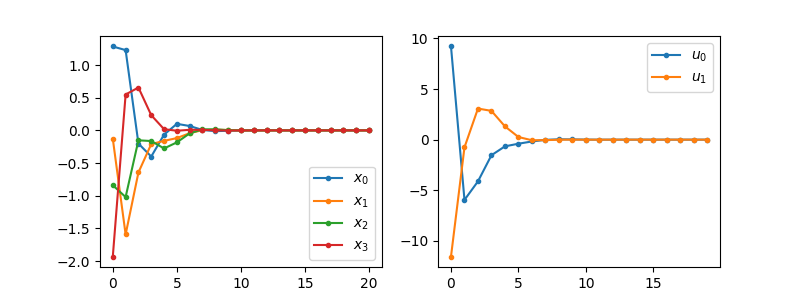

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i in range(X.shape[-1]):
    ax[0].plot(X[:, i], label=f"$x_{i}$", marker=".")
ax[0].legend()

for i in range(U.shape[-1]):
    ax[1].plot(U[:, i], label=f"$u_{i}$", marker=".")
ax[1].legend()
plt.show()

# Nonlinear dynamics and cost example

In [48]:
def car(x, u, p):
    """
    unicycle car dynamics, 4 states, 2 actions
    x1: position x
    x2: position y
    x3: speed (local frame)
    x4: orientation angle

    u1: acceleration
    u2: turning speed (independent of velocity)
    """
    assert x.shape[-1] == 4 and u.shape[-1] == 2
    v_scale, w_scale, T = p[..., 0], p[..., 1], p[..., 2]
    eps = 1e-6
    u1, u2 = v_scale * u[..., 0], w_scale * -u[..., 1]
    u1 = u1 + jnp.where(u1 >= 0.0, eps, -eps)
    u2 = u2 + jnp.where(u2 >= 0.0, eps, -eps)

    x0, y0, v0, th0 = x[..., 0], x[..., 1], x[..., 2], x[..., 3]
    xp1 = (
        x0
        + (
            u2 * jnp.sin(T * u2 + th0) * v0
            + T * u1 * u2 * jnp.sin(T * u2 + th0)
            + u1 * jnp.cos(T * u2 + th0)
        )
        / u2**2
        - (jnp.sin(th0) * u2 * v0 + jnp.cos(th0) * u1) / u2**2
    )
    xp2 = (
        y0
        - (
            u2 * jnp.cos(T * u2 + th0) * v0
            - u1 * jnp.sin(T * u2 + th0)
            + T * u1 * u2 * jnp.cos(T * u2 + th0)
        )
        / u2**2
        + (jnp.cos(th0) * u2 * v0 - jnp.sin(th0) * u1) / u2**2
    )
    xp3 = v0 + T * u1
    xp4 = T * u2 + th0
    xp = jnp.stack([xp1, xp2, xp3, xp4], -1)
    return xp


def fx_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jnp.moveaxis(jacobian(lambda x: jnp.sum(car(x, u, p), sum_dims))(x), 0, -2)


def fu_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jnp.moveaxis(jacobian(lambda u: jnp.sum(car(x, u, p), sum_dims))(u), 0, -2)


@jit
def f_fx_fu_fn(x, u, p=None):
    if p is None:
        p = jnp.array([1.0, 1.0, 0.3])
    return car(x, u, p), fx_(x, u, p), fu_(x, u, p)




In [54]:
p = Problem(N=50, xdim=4, udim=2, verbose=False)
p.f_fx_fu_fn = f_fx_fu_fn
p.X_ref = np.ones(p.xdim)
X_ref2 = 3 * np.ones(p.X_ref.shape)


def lin_cost_fn(x, u, problem):
    return (x - X_ref2), None

p.lin_cost_fn = lin_cost_fn
p.Q = np.concatenate([p.Q[:-1, ...], 1e2 * p.Q[-1:, ...]])
u_lim = 1e0
p.u_l = -u_lim * np.ones(p.udim)
p.u_u = u_lim * np.ones(p.udim)
p.max_it = 100
p.slew_rate = 1e0

X, U, _ = solve(**p)

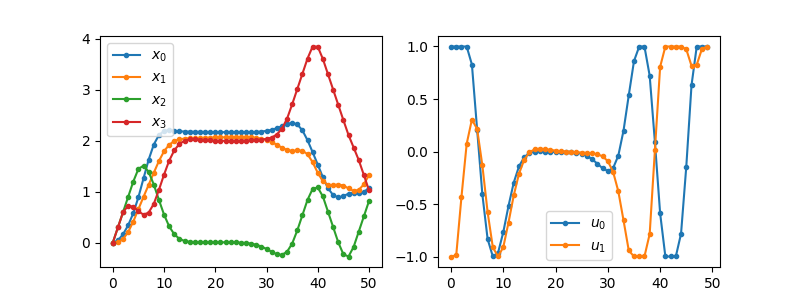

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i in range(X.shape[-1]):
    ax[0].plot(X[:, i], label=f"$x_{i}$", marker=".")
ax[0].legend()

for i in range(U.shape[-1]):
    ax[1].plot(U[:, i], label=f"$u_{i}$", marker=".")
ax[1].legend()
plt.show()

# Linear dynamics, consensus optimization

In [56]:
# we specify M, the number of particles and Nc, consensus horizon
p = Problem(xdim=4, udim=2, N=20, M=2, Nc=3, max_it=100, verbose=False)
p.x0 = 1 * np.ones(p.xdim)
p.X_ref = np.tile(np.stack([np.ones(p.xdim), -np.ones(p.xdim)], 0)[:, None, :], (1, p.N, 1))
A = np.random.randn(p.xdim, p.xdim) + 0.3 * np.eye(p.xdim)
A = np.tile(A, (p.M, p.N, 1, 1))
B = np.tile(np.array([[0.0, 0.0, 0.0, 0.3], [0.0, 0.0, 0.3, 0.0]]).T, (p.M, p.N, 1, 1))

# control lost for one particle after timestep 10
B[1, 10:, :, :] = 0.0


def linear_dynamics_f_fx_fu_fn(x, u, p=None):
    xp = (A @ x[..., None])[..., 0] + (B @ u[..., None])[..., 0]
    return xp, A, B


p.f_fx_fu_fn = linear_dynamics_f_fx_fu_fn
X, U, _ = solve(**p)
# actions differ after Nc = 3
print(U[0, ...] - U[1, ...])


[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.89880027 -0.17406918]
 [-0.27620558  0.5950375 ]
 [-2.14946656  0.87451954]
 [-2.7445054   0.64492506]
 [-2.60756835  0.56028935]
 [-2.44130422  0.74698949]
 [-2.53455651  0.56261569]
 [-1.27679231  0.28282682]
 [-1.27734562  0.28224436]
 [-1.27691589  0.28005124]
 [-1.27470208  0.28449265]
 [-1.26947207  0.30279122]
 [-1.28446964  0.23986513]
 [-1.3438066   0.37601512]
 [-1.37048703 -0.31513834]
 [-1.13102653  0.88555375]
 [ 0.35922776  1.75025141]]


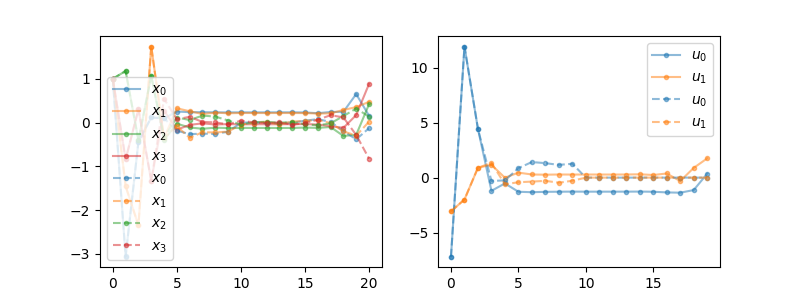

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for r in range(p.M):
    for i in range(X.shape[-1]):
        ax[0].plot(
            X[r, :, i],
            label=f"$x_{i}$",
            marker=".",
            linestyle="-" if r == 0 else "--",
            color=f"C{i}",
            alpha=0.5,
        )
ax[0].legend()

for r in range(p.M):
    for i in range(U.shape[-1]):
        ax[1].plot(
            U[r, :, i],
            label=f"$u_{i}$",
            marker=".",
            linestyle="-" if r == 0 else "--",
            color=f"C{i}",
            alpha=0.5,
        )
ax[1].legend()
plt.show()